# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from random import randint
import utils
import time

import math
import functools
import operator
from IPython.display import Math
from IPython.core.debugger import set_trace

device = torch.device("cuda")

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(f'{sum(p.numel() for p in net.parameters() if p.requires_grad)} parameters')

6653200 parameters


# ToDo:
+ Sentiment Analysis using RNN?
+ Stack RNN
+ GRU
+ Speech Recognition (Spectogram)
+ MT 
+ Bidirectional LSTM
+ ConvNet for NLP
+ Attention CNN?


# 5. CNN (labs_lecture08)

In [3]:
import torch
import numpy as np
import math

## 5.1 Conv2D Layer

In [4]:
def calc_conv_output(N, F, P=0, S=1):
    return int(math.floor((N+2*P-F)/S + 1))

In [5]:
def comp_conv2d(conv2d, X):
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    #X = X.reshape((bs, nc) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: examples and
    # channels
    return Y.shape[2:]
    #return Y.reshape(Y.shape[2:])

In [6]:
bs, nc = 1, 1
x = torch.rand(bs, nc, 6,6)
conv2d1 = nn.Conv2d(in_channels=nc, out_channels=5, kernel_size=3, padding=1)
print(f"filter size: {conv2d1.weight.size()}") # filter size
y = conv2d1(x); print(f"output size: {y.size()}")
print(f"computed size: {calc_conv_output(6, 3, P=1, S=1)}")
print(f"computed size: {comp_conv2d(conv2d1, x)}")

filter size: torch.Size([5, 1, 3, 3])
output size: torch.Size([1, 5, 6, 6])
computed size: 6
computed size: torch.Size([6, 6])


## 5.2 Padding

In [7]:
def get_padding(N, F, S=1):
    """Computes same padding"""
    P = ((S-1)*N-S+F)/2
    print(f"pad: {P}")
    return int(P)

In [8]:
print(f"padding: {get_padding(6, 3)}")

pad: 1.0
padding: 1


In [9]:
conv2d2 = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 2))
print(f"computed size: {comp_conv2d(conv2d2, x)}")

computed size: torch.Size([6, 8])


## 5.3 Pooling

In [10]:
x = torch.rand(1,2,6,6)
max_pool = nn.MaxPool2d(2,2)
avg_pool = nn.AvgPool2d(2,2)
adp_max_pool = nn.AdaptiveMaxPool2d((2,2))

print(x)
after_mp = max_pool(x); print(after_mp.size())
print(after_mp)
after_ap = avg_pool(x); print(after_ap.size())
print(after_ap)
after_amp = adp_max_pool(x); print(after_amp.size())
print(after_amp)

tensor([[[[0.4252, 0.5256, 0.9016, 0.9738, 0.1749, 0.5098],
          [0.2569, 0.6369, 0.2054, 0.8163, 0.5875, 0.4681],
          [0.5969, 0.7077, 0.5774, 0.9721, 0.2460, 0.7573],
          [0.4752, 0.7360, 0.3614, 0.5428, 0.3666, 0.6142],
          [0.9727, 0.7532, 0.5712, 0.7669, 0.3450, 0.8892],
          [0.3048, 0.1747, 0.9293, 0.4978, 0.7745, 0.3060]],

         [[0.1194, 0.5136, 0.4161, 0.9292, 0.1764, 0.9836],
          [0.2437, 0.3880, 0.8240, 0.6900, 0.8286, 0.4023],
          [0.8131, 0.5747, 0.4015, 0.3696, 0.2569, 0.1663],
          [0.5540, 0.5938, 0.7130, 0.4867, 0.0861, 0.6473],
          [0.0166, 0.8278, 0.2405, 0.0504, 0.5603, 0.6847],
          [0.6472, 0.2229, 0.2747, 0.8148, 0.6128, 0.5177]]]])
torch.Size([1, 2, 3, 3])
tensor([[[[0.6369, 0.9738, 0.5875],
          [0.7360, 0.9721, 0.7573],
          [0.9727, 0.9293, 0.8892]],

         [[0.5136, 0.9292, 0.9836],
          [0.8131, 0.7130, 0.6473],
          [0.8278, 0.8148, 0.6847]]]])
torch.Size([1, 2, 3, 3])
tens

## 5.4 LeNet5 Architecture

In [11]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [12]:
def compute_train_data_statistics(train_data, device=device):
    mean= train_data.mean().to(device)
    std = train_data.std().to(device)
    return mean, std

mean, std = compute_train_data_statistics(train_data)
print(f"Train data mean: {mean}, std: {std}")

Train data mean: 0.13066235184669495, std: 0.30810782313346863


In [13]:
import functools
import operator

class LeNet5(nn.Module):
    def __init__(self, input_dims=(1,28,28)):
        super(LeNet5, self).__init__()
        self.CL1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=3, padding=get_padding(50, 3))
        # 50 x 28 x 28
        self.MP1 = nn.MaxPool2d(2,2)
        # 50 x 14 x 14
        self.CL2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3, padding=get_padding(100, 3))
        # 100 x 14 x 14
        self.MP2 = nn.MaxPool2d(2,2)
        # 100 x 7 x 7 = 4900
        
        features = nn.Sequential(self.CL1, self.MP1, self.CL2, self.MP2)
        num_feats_aft_conv = functools.reduce(operator.mul, list(features(torch.rand(1, *(input_dims))).shape)); #print(num_feats_aft_conv)
        
        self.LL1 = nn.Linear(num_feats_aft_conv, 100) #4900
        self.LL2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.CL1(x)
        x = F.relu(x)
        
        x = self.MP1(x)
        
        x = self.CL2(x)
        x = F.relu(x)
        
        x = self.MP2(x)
        
        #x1 = x.view(-1, 4900); print(x1.shape)
        x = torch.flatten(x, 1)#; print(x.shape)
        x = self.LL1(x)
        x = F.relu(x)
        
        x = self.LL2(x)
        return x

In [14]:
net = LeNet5().to(device)
print(net)
utils.display_num_param(net)

pad: 1.0
pad: 1.0
LeNet5(
  (CL1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MP1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CL2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MP2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (LL1): Linear(in_features=4900, out_features=100, bias=True)
  (LL2): Linear(in_features=100, out_features=10, bias=True)
)
There are 536710 (0.54 million) parameters in this neural network


In [15]:
def eval_on_test_set():
    running_error = 0
    num_batches = 0
    for i in range(0, len(test_data), bs):
        #set_trace()
        minibatch_data = test_data[i:i+bs].to(device)
        minibatch_label = test_label[i:i+bs].to(device)
        inputs = minibatch_data.unsqueeze(dim=1) # add batch dim (color no need)
        inputs = (inputs - mean)/std   # normalize inputs
        scores = net(inputs)
        error = utils.get_error(scores, minibatch_label)
        running_error += error.detach().item()
        num_batches += 1
    total_error = running_error / num_batches
    print(f"=> test error: {total_error*100:.5f}% \n")

In [16]:
criterion = nn.CrossEntropyLoss()
bs = 128
lr = 0.25

In [17]:
start = time.time()
for epoch in range(1,31):
    # update learning rate
    if epoch % 5 == 0:
        lr = lr / 2
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(len(train_data))
 
    for count in range(0,len(train_data),bs):
        optimizer.zero_grad()
        
        
        indices=shuffled_indices[count:count+bs]         # [128]
        minibatch_data = train_data[indices].to(device)  # [128, 28, 28]
        minibatch_label= train_label[indices].to(device) # [128]
        
        # add batch dimension (color no need)
        inputs = minibatch_data.unsqueeze(dim=1)         # [128, 1, 28, 28]
        inputs = (inputs - mean)/std # normalize inputs
        
        inputs.requires_grad_()

        scores= net(inputs)                              # [128, 10]
        loss =  criterion(scores, minibatch_label) 
        loss.backward()
        optimizer.step()
        
        # COMPUTE STATS
        running_loss += loss.detach().item()
        error = utils.get_error(scores.detach(), minibatch_label)
        running_error += error.detach().item()
        num_batches += 1
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed_time = (time.time()-start)/60
    
    print(f"epoch={epoch}, time={elapsed_time:.5f} min, loss={total_loss:.5f}, train error={total_error*100:.5f}%, lr={lr:.5f}")
    eval_on_test_set() 

epoch=1, time=0.07462 min, loss=0.26874, train error=8.60874%, lr=0.25000
=> test error: 1.62184% 

epoch=2, time=0.12309 min, loss=0.04827, train error=1.51142%, lr=0.25000
=> test error: 1.24604% 

epoch=3, time=0.17206 min, loss=0.03330, train error=1.01279%, lr=0.25000
=> test error: 1.11748% 

epoch=4, time=0.22381 min, loss=0.02494, train error=0.82789%, lr=0.25000
=> test error: 0.94937% 

epoch=5, time=0.27419 min, loss=0.01423, train error=0.40367%, lr=0.12500
=> test error: 0.98892% 

epoch=6, time=0.32437 min, loss=0.01092, train error=0.30817%, lr=0.12500
=> test error: 0.83070% 

epoch=7, time=0.37669 min, loss=0.00870, train error=0.20989%, lr=0.12500
=> test error: 0.85047% 

epoch=8, time=0.42883 min, loss=0.00719, train error=0.18157%, lr=0.12500
=> test error: 0.75158% 

epoch=9, time=0.48514 min, loss=0.00592, train error=0.15492%, lr=0.12500
=> test error: 0.76147% 

epoch=10, time=0.54109 min, loss=0.00381, train error=0.06497%, lr=0.06250
=> test error: 0.76147% 


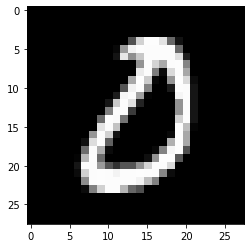

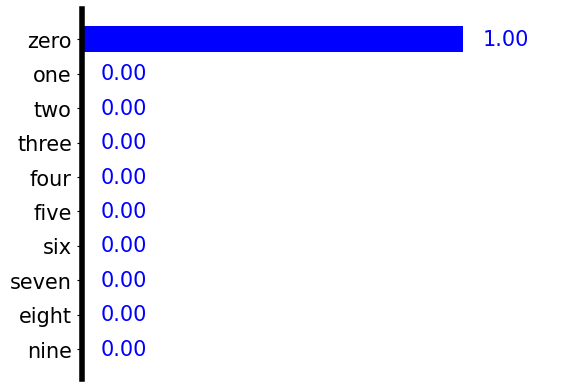

In [18]:
# choose a picture at random
idx = randint(0, len(test_data)-1)
im = test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im= (im-mean) / std
im= im.view(1,28,28).unsqueeze(dim=1) #cifar im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_mnist(probs.cpu())

# 6. RNN (labs_lecture10)
+ Perplexity = exp(loss)

## 6.1 Load Penn Tree Bank Corpus

In [ ]:
from utils import check_ptb_dataset_exists
data_path = check_ptb_dataset_exists('../data/'); print(data_path)

train_data  =  torch.load(data_path+'ptb/train_data.pt')
test_data   =  torch.load(data_path+'ptb/test_data.pt')

print(train_data.size()) # 20 batches (sub-documents) of 46k words
print(test_data.size())
print(f"sanity check: ({len(train_data)}+{len(test_data)})x20 = {(len(train_data)+len(test_data))*20} words")

## 6.2 Three Layer VRNN
+ 1 hidden state represented by vector h of embedding size (e.g. 150)
+ $h_t = tanh( Rh_{t-1} + Vg_{t} )$

In [ ]:
vocab_size = 10000
hidden_size = 150 # Embedding size

In [ ]:
class three_layer_rnn(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.layer1 = nn.Embedding(vocab_size, hidden_size)
        self.layer2 = nn.RNN(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, word_seq, h_init):
        # word_seq = [sent_len, batch_size]
        g_seq = self.layer1(word_seq)             # [35, 20] -> [35, 20, 150]
        # g_seq (embedding) = [sent_len, batch_size, emb dim]
        h_seq, h_out = self.layer2(g_seq, h_init) # seq: [35, 20, 150], h: [1, 20, 150]
        # h_seq = [sent_len, batch_size, emb dim]
        # h_out = [1, batch_size, emb dim]
        score_seq = self.layer3(h_seq)            # [1, 20, 150]
        
        return score_seq, h_out

In [ ]:
net = three_layer_rnn(vocab_size, hidden_size).to(device)
print(net)
utils.display_num_param(net)

### 6.2.1 Initialize Weights

In [ ]:
print(net.layer1.weight.data) # embedding
print(net.layer3.weight.data) # linear

# initialize weights of Embedding and Linear layers
net.layer1.weight.data.uniform_(-0.1, 0.1)
net.layer3.weight.data.uniform_(-0.1, 0.1)

print(net.layer1.weight.data) # embedding
print(net.layer3.weight.data) # linear

### 6.2.2 Training three-layer RNN

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr = 1
bs = 20 # data already prepared in batches of 20.
seq_length = 35

In [ ]:
def eval_on_test_set():
    running_loss=0
    num_batches=0    
       
    h = torch.zeros(1, bs, hidden_size).to(device) #[1, 20, 150]

    for count in range(0, len(test_data)-seq_length, seq_length) :  
        minibatch_data =  test_data[count   : count+seq_length  ].to(device) #[35, 20]
        minibatch_label = test_data[count+1 : count+seq_length+1].to(device) #[35, 20] shift by one word
                                  
        scores, h = net(minibatch_data, h) # scores: [35, 20, 10000]
        
        scores          =  scores.view(bs*seq_length, vocab_size) #[700, 10000]
        minibatch_label =  minibatch_label.view(bs*seq_length)    #[700]  
        
        loss = criterion(scores, minibatch_label)    
        
        h = h.detach()
            
        running_loss += loss.detach().item()
        num_batches += 1        
    
    total_loss = running_loss/num_batches 
    print(f"=> test exp(loss): {math.exp(total_loss):.5f} \n")

In [ ]:
start=time.time()

for epoch in range(10):
    # keep the learning rate to 1 during the first 4 epochs, then divide by 1.1 at every epoch
    if epoch >= 4:
        my_lr = my_lr / 1.1
    # create a new optimizer and give the current learning rate.   
    optimizer=torch.optim.SGD(net.parameters(), lr=my_lr)
        
    # set the running quantities to zero at the beginning of the epoch
    running_loss=0
    num_batches=0    
    # set the initial h to be the zero vector
    h = torch.zeros(1, bs, hidden_size).to(device) #one word, bs documents, embedding size

    for count in range(0, len(train_data)-seq_length, seq_length):
        
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch
        minibatch_data =  train_data[count   : count+seq_length  ].to(device) # [35, 20]
        minibatch_label = train_data[count+1 : count+seq_length+1].to(device) # [35, 20]       
        
        # Detach to Stop backpropagation to go beyond the current mini-batch
        # Then tell Pytorch to start tracking all operations that will be done on h
        h = h.detach()
        h = h.requires_grad_()
                       
        # forward the minibatch through the net        
        scores, h = net(minibatch_data, h)                                    # [35, 20, 10000]
        
        # reshape the scores and labels to huge batch of size bs*seq_length
        scores          = scores.view(bs*seq_length, vocab_size)              # [700, 10000]
        minibatch_label = minibatch_label.view(bs*seq_length)                 # [700]
        
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(scores, minibatch_label)
        
        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()

        # do one step of stochastic gradient descent: R=R-lr(dL/dR), V=V-lr(dL/dV), ...
        utils.normalize_gradient(net) # prevent exploding gradients in RNNs.
        optimizer.step()              # update weights

        # update the running loss  
        running_loss += loss.detach().item()
        num_batches += 1
        
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    elapsed = time.time()-start/60
    
    print(f"epoch={epoch}, time={elapsed:.5f} min, exp(loss)={math.exp(total_loss):.5f} lr={my_lr:.5f}")
    eval_on_test_set() 

### 6.2.3 Testing three-layer RNN

In [ ]:
sentence1 = "some analysts expect oil prices to remain relatively"
sentence2 = "over the next days and weeks they say investors should look for stocks to"
sentence3 = "prices averaging roughly $ N a barrel higher in the third"
sentence4 = "i think my line has been very consistent mrs. hills said at a news"
sentence5 = "this appears particularly true at gm which had strong sales in"
# or make your own sentence.  No capital letter or punctuation allowed. Each word must be in the allowed vocabulary.
sentence6= "he was very"
mysentence = sentence6

In [ ]:
test_sen=utils.sentence2vector(mysentence).to(device)
print(minibatch_data)

In [ ]:
h = torch.zeros(1, 1, hidden_size).to(device) # one word, one document
scores, h = net(test_sen, h)

In [ ]:
print(mysentence, '... \n')
utils.show_next_word(scores)

## 6.3 Long Short-Term Memory (LSTM)
+ 2 hidden states represented by 2 vectors h and c of embedding size (e.g. 200)
    + Vector h stores the short-term dependencies
    + Vector c records the long-term dependencies

In [ ]:
bs = 20
vocab_size = 10000

In [ ]:
class three_layer_lstm(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.layer1 = nn.Embedding(vocab_size, hidden_size)
        self.layer2 = nn.LSTM(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, word_seq, h_init, c_init):
        g_seq                 = self.layer1(word_seq)
        h_seq, (h_out, c_out) = self.layer2(g_seq, (h_init, c_init))
        score_seq             = self.layer3(h_seq)
        return score_seq, h_out, c_out

In [ ]:
hidden_size = 300
net = three_layer_lstm(vocab_size, hidden_size).to(device)
print(net)
utils.display_num_param(net)

### 6.3.1 Initialize Weights

In [ ]:
# initialize weights of Embedding and Linear layers
net.layer1.weight.data.uniform_(-0.1, 0.1)
net.layer3.weight.data.uniform_(-0.1, 0.1)
print('')

### 6.3.2 Training three-layer LSTM

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr = 5
seq_length = 35

In [ ]:
def eval_on_test_set():
    running_loss = 0
    num_batches = 0
    h = torch.zeros(1, bs, hidden_size).to(device)
    c = torch.zeros(1, bs, hidden_size).to(device)
    for count in range(0, len(test_data)-seq_length, seq_length):
        minibatch_data =  test_data [count  : count+seq_length  ].to(device)
        minibatch_label = test_data[count+1: count+seq_length+1].to(device)
        
        scores, h, c = net(minibatch_data, h, c)
        
        scores          = scores.view(bs*seq_length, vocab_size)
        minibatch_label = minibatch_label.view(bs*seq_length)
        
        loss = criterion(scores, minibatch_label)
        
        h = h.detach()
        c = c.detach()
        
        running_loss += loss.detach().item()
        num_batches += 1
    total_loss = running_loss / num_batches
    print(f"=> test exp(loss): {math.exp(total_loss):.5f} \n")

In [ ]:
start=time.time()

for epoch in range(8):
    # divide the learning rate by 3 except after the first epoch
    if epoch >= 2:
        my_lr = my_lr / 3
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
    
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    num_batches=0    

    # set the initial h and c to be the zero vector
    h = torch.zeros(1, bs, hidden_size).to(device)
    c = torch.zeros(1, bs, hidden_size).to(device)
    
    for count in range(0 , len(train_data)-seq_length, seq_length):
        optimizer.zero_grad()
        
        # create a minibatch
        minibatch_data =  train_data[count  :count+seq_length  ].to(device)
        minibatch_label = train_data[count+1:count+seq_length+1].to(device)        
        
        h=h.detach()
        c=c.detach()
        h=h.requires_grad_()
        c=c.requires_grad_()
                       
        # forward the minibatch through the net        
        scores, h, c = net(minibatch_data, h, c)
        
        scores          =  scores.view(bs*seq_length, vocab_size)  
        minibatch_label =  minibatch_label.view(bs*seq_length)       
        loss = criterion(scores, minibatch_label)
        loss.backward()

        utils.normalize_gradient(net)
        optimizer.step()
        
        running_loss += loss.detach().item()
        num_batches += 1
        
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    
    print(f"epoch={epoch}, time={elapsed:.5f} min, exp(loss)={math.exp(total_loss):.5f} lr={my_lr:.5f}")
    eval_on_test_set() 

In [ ]:
mysentence = sentence6
test_sen = utils.sentence2vector(mysentence).to(device)
h = torch.zeros(1, 1, hidden_size).to(device)
c = torch.zeros(1, 1, hidden_size).to(device)
scores , h, c = net(test_sen , h, c)
print(mysentence, '... \n')
utils.show_next_word(scores)

## 6.4 [Additional] Bidirectional LSTM (BiLSTM) WEIRD

In [ ]:
bs = 20
vocab_size = 10000
hidden_size = 200

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.layer1 = nn.Embedding(vocab_size, hidden_size)
        self.layer2 = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True)
        self.layer3 = nn.Linear(hidden_size*2, num_classes) # bidirectional
        
    def forward(self, word_seq, h_init, c_init):
        g_seq                 = self.layer1(word_seq)
        h_seq, (h_out, c_out) = self.layer2(g_seq, (h_init, c_init))
        score_seq             = self.layer3(h_seq)
        return score_seq, h_out, c_out

In [ ]:
net = BiLSTM(vocab_size, hidden_size, 1, vocab_size).to(device)
print(net)
utils.display_num_param(net)
net.layer1.weight.data.uniform_(-0.1, 0.1)
net.layer3.weight.data.uniform_(-0.1, 0.1)
print('')

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr = 5
seq_length = 35

In [ ]:
def eval_on_test_set():
    running_loss = 0
    num_batches = 0
    h = torch.zeros(2, bs, hidden_size).to(device) # bidirectional
    c = torch.zeros(2, bs, hidden_size).to(device) # bidirectional
    for count in range(0, len(test_data)-seq_length, seq_length):
        minibatch_data =  test_data [count  : count+seq_length  ].to(device)
        minibatch_label = test_data[count+1: count+seq_length+1].to(device)
        
        scores, h, c = net(minibatch_data, h, c)
        
        scores          = scores.view(bs*seq_length, vocab_size)
        minibatch_label = minibatch_label.view(bs*seq_length)
        
        loss = criterion(scores, minibatch_label)
        
        h = h.detach()
        c = c.detach()
        
        running_loss += loss.detach().item()
        num_batches += 1
    
    set_trace()
    total_loss = running_loss / num_batches
    print(f"=> test exp(loss): {math.exp(total_loss):.5f} \n")

In [ ]:
start=time.time()

for epoch in range(8):
    # divide the learning rate by 3 except after the first epoch
    if epoch >= 2:
        my_lr = my_lr / 3
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
    
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    num_batches=0    

    # set the initial h and c to be the zero vector
    h = torch.zeros(2, bs, hidden_size).to(device) # bidirectional
    c = torch.zeros(2, bs, hidden_size).to(device) # bidirectional
    
    for count in range(0 , len(train_data)-seq_length, seq_length):
        optimizer.zero_grad()
        
        # create a minibatch
        minibatch_data =  train_data[count  :count+seq_length  ].to(device)
        minibatch_label = train_data[count+1:count+seq_length+1].to(device)        
        
        h=h.detach()
        c=c.detach()
        h=h.requires_grad_()
        c=c.requires_grad_()
                       
        # forward the minibatch through the net
        scores, h, c = net(minibatch_data, h, c)
        
        scores          =  scores.view(bs*seq_length, vocab_size)  
        minibatch_label =  minibatch_label.view(bs*seq_length)       
        loss = criterion(scores, minibatch_label)
        loss.backward()

        utils.normalize_gradient(net)
        optimizer.step()
        
        running_loss += loss.detach().item()
        num_batches += 1
        
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    
    print(f"epoch={epoch}, time={elapsed:.5f} min, exp(loss)={math.exp(total_loss):.5f} lr={my_lr:.5f}")
    eval_on_test_set() 

In [ ]:
mysentence = sentence6
test_sen = utils.sentence2vector(mysentence).to(device)
h = torch.zeros(2, 1, hidden_size).to(device)
c = torch.zeros(2, 1, hidden_size).to(device)
scores , h, c = net(test_sen , h, c)
print(mysentence, '... \n')
utils.show_next_word(scores)